In [22]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *
from forecasting import mape_error
from models import *

import pandas as pd
import tensorflow as tf
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

In [23]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")

all_atms_feature_set = get_all_atms_feature_set(df, first_n = 500)

In [24]:
all_atms_feature_set = add_cluster_features(all_atms_feature_set,
    [('Day_of_the_Week_Index', 7),
    ('Special_Lunar_Dates_Index', 9),
    ('Month_of_the_Year_Index', 10)],
    'CashIn', KMeans)
    
all_atms_feature_set.sort_index(inplace = True)

In [25]:
categorical_features = [cat for cat in all_atms_feature_set.select_dtypes(include=['int8', 'int64'])
    if cat not in ['AtmId', 'Day_Index_0', 'Day_Index_1', 'Day_Index_2',
    'Day_Index_3', 'Day_Index_4', 'Day_Index_5', 'Day_Index_6', 'Is_Weekend',
    'curr_month_1_delta', 'curr_month_15_delta', 'next_month_1_delta',
    'is_ramazan', 'ramazan_in_7_days', 'is_kurban', 'kurban_in_7_days']]
continuous_features = [cont for cont in all_atms_feature_set.select_dtypes(include='float64')
    if cont not in ['CashIn', 'CashOut']]

all_features = []
all_features.extend(categorical_features)
all_features.extend(continuous_features)

X = all_atms_feature_set[all_features]
y = all_atms_feature_set['CashIn']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

train_pool = Pool(data = X_train, label = y_train, cat_features=categorical_features)

In [26]:
cb = CatBoostRegressor()
cb.fit(train_pool, verbose=0)

### MAPE Error

In [27]:
"Train score: %.4f, test score: %.4f" % (mape_error(cb.predict(X_train), y_train, use_index=False), mape_error(cb.predict(X_test), y_test, use_index=False))

'Train score: 35.7964, test score: 36.5196'

### NMAE Error

In [ ]:
def nmae_error(y_actual, y_pred):
    return (y_pred - y_actual).abs().sum() / y_actual.sum()

In [36]:
"Train score: %.4f, test score: %.4f" % (nmae_error(cb.predict(X_train), y_train), nmae_error(cb.predict(X_test), y_test))

'Train score: 0.2752, test score: 0.2705'

<AxesSubplot:xlabel='features'>

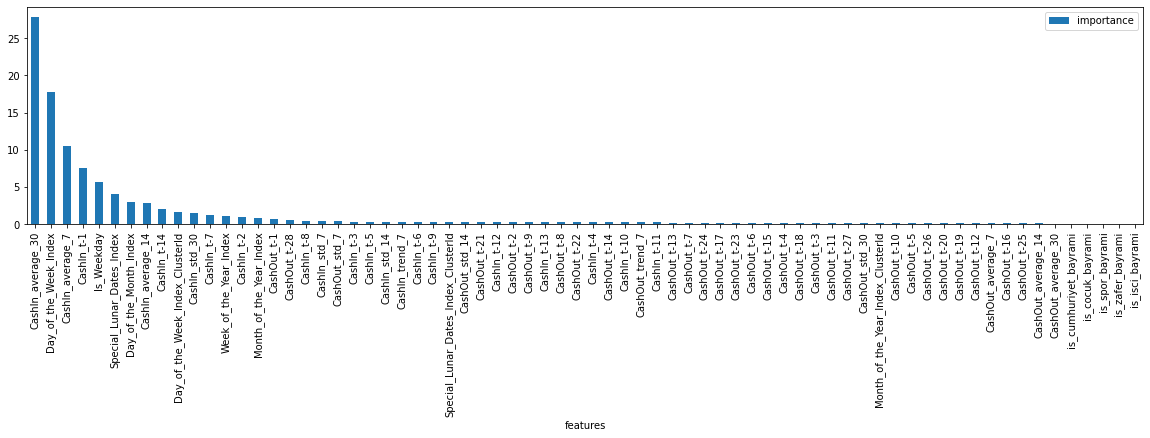

In [28]:
feature_importance = cb.get_feature_importance(train_pool)
importance_df = pd.DataFrame({'features':all_features, 'importance':feature_importance})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
importance_df.plot.bar(x='features', y='importance',figsize=(20,4))


## Plotting

In [29]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [30]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)
    print(weekly_errors.mean())

In [31]:
ATM_ID = 33821
atm_feature_set = all_atms_feature_set[all_atms_feature_set['AtmId'] == ATM_ID]
draw_model_error(cb, atm_feature_set[all_features], atm_feature_set['CashIn'], split_from=X_train.index[-1])

54.49166573581754
